## Chapter 3
# Spectral Analysis and Synthesis

### Additive Synthesis

Fourier synthesis states that we can create any periodic vibration by adding sinusoids together with frequencies that are integer multiples of a fundamental frequency (harmonics) at particular amplitudes and phases.  Thus, Fourier synthesis is also known as _additive synthesis_.

For example, a clarinet-like tone can be constructed from the following rules:

* Only odd-numbered harmonics are present.
* Amplitudes of harmonics decreases as the harmonic number increases.

$s(t) = \sum_\limits{n=1}^\limits{\infty}\frac{1}{n}sin(n\omega t + 0)$  such that $n$ is odd.

In [1]:
import sys
sys.path.append('../')

In [2]:
from NoteSequence import render_samples_ipython
from conversion import SAMPLES_PER_SECOND
from generators import generate_sine
from AR import AR

import numpy as np

fundamental = 100
N = 20
frequencies_and_amplitudes = [(n * fundamental, 1 / n) for n in range(1, N, 2)]

samples = np.array([amplitude * np.sin(2 * np.pi * frequency * np.linspace(0, 3, SAMPLES_PER_SECOND * 3)) for frequency, amplitude in frequencies_and_amplitudes]).sum(axis=0)
AR().apply(samples) # envelope
render_samples_ipython(samples)

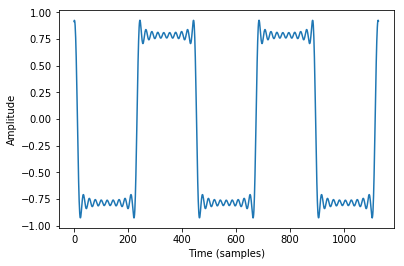

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(samples[5500:6628])
plt.xlabel('Time (samples)')
l = plt.ylabel('Amplitude')

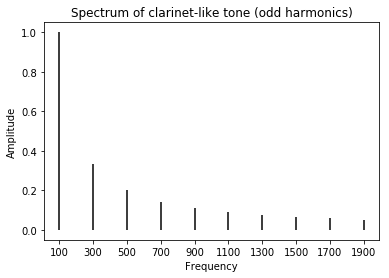

In [4]:
frequencies, amplitudes = zip(*frequencies_and_amplitudes)
plt.vlines(x=frequencies, ymin=0, ymax=amplitudes)
plt.xticks(frequencies)
plt.title('Spectrum of clarinet-like tone (odd harmonics)')
plt.xlabel('Frequency')
l = plt.ylabel('Amplitude')

### Constructing a Frequency Detector

The fundamental insight of the Fourier transform is:

_**The more positive the product signal is, the closer the source signals are to being identical.**_

_**The more mixed positive and negative the product signal is, the less identical are the source signals.**_

In [5]:
from ipython_animation import create_animation, DEFAULT_FPS
import matplotlib.cm as cm

N = 100
frequency_stationary = 4
frequency_changing = 0.05
animation_length_seconds = 6
num_frames = animation_length_seconds * DEFAULT_FPS

fig = plt.figure(figsize=(10, 10))
test_signal = np.sin(2 * np.pi * frequency_stationary * np.linspace(0, 1, N))
probe_signal = np.sin(2 * np.pi * frequency_changing * np.linspace(0, 1, N))
product_plot = plt.subplot(311)
product_plot.set_title('Product of two sinusoid signals\n(More positive product == closer to identical)', size=14)
test_line, = product_plot.plot(test_signal, linewidth=3, label='Test signal')
probe_line, = product_plot.plot(probe_signal, linewidth=3, label='Probe signal')
product_plot.legend(loc='upper right')
product_signal_plot = plt.subplot(312)
product_line, = product_signal_plot.plot(test_signal * probe_signal, linewidth=3)
product_signal_plot.set_ylim(-1.1, 1.1)
product_signal_plot.set_title('Product signal')

product_sum_plot = plt.subplot(313)
product_sums = np.array([np.arange(num_frames), np.zeros(num_frames)]).T
product_sum_colors = ['w'] * num_frames
product_sum_line = product_sum_plot.scatter(product_sums[:,0], product_sums[:,1], color=product_sum_colors, s=12)

product_sum_plot.set_ylim(-20, (test_signal ** 2).sum() + 5)
product_sum_plot.set_title('Product sum')
plt.tight_layout()

def animate(i):
    probe_signal = np.sin(2 * np.pi * i * frequency_changing * np.linspace(0, 1, N))
    probe_line.set_ydata(probe_signal)
    product_signal = test_signal * probe_signal
    product_line.set_ydata(product_signal)
    product_sums[i,1] = product_signal.sum()
    color = cm.coolwarm(product_sums[i,1] / (test_signal ** 2).sum())
    product_sum_colors[i] = color
    product_line.set_color(color)
    product_sum_plot.set_title('Product sum = %0.01f' % product_signal.sum(), color=color)
    product_sum_line.set_offsets(product_sums)
    product_sum_line.set_color(product_sum_colors)

create_animation(fig, plt, animate, length_seconds=6)

### Continuous Fourier Transform

The picture above basically _is_ the Fourier transform! To make it formal we use a complex sinusoid (a phasor) $e^{-i2\pi ft}$.  The negative sign makes it spin clockwise (although it would work spinning in either direction).

We take the product of the test signal (the input), $x(t)$, with our probe phasor to get

$x(t) e^{-i2\pi ft}$.

We sum over the product of these signals over all time:

$X(f) = \int_\limits{-\infty}^\limits{\infty} x(t) e^{-i2\pi ft} dt$

The result of the equation $X(f)$ is a _spectrum_.  The value of $X(f)$ shows the amount of energy in the input signal at each frequency $f$.

### Inverse Fourier Transform

Whereas the Fourier transform starts with a function of time and produces a function of frequency, the inverse Fourier transform starts with a function of frequency and produces a function of time. It synthesizes a signal from the specification given by its spectrum. (See **Additive Synthesis** above!)

The IFT is defined as:

$x(t) = \int_\limits{-\infty}^\limits{\infty}X(f)e^{i2\pi ft}df$

$X(f)$ is the amount of energy of the frequency $f$.  It acts as the amplitude of the complex sinusoid $e^{i2\pi ft}$ at the same frequency.  Thus, for time $t$ we are adding up all the values of individual sinusoids with frequency $f$ at time $t$, scaled by their given magnitudes.

### Discrete Fourier Transform

Definition:

$X(k) = \frac{1}{N}\sum_\limits{n=0}^\limits{N-1}x(n)e^{-ik\omega n / N}$

Note that we scale the output by $\frac{1}{N}$, where $N$ is the length of the input signal, since summing the product two discrete signals will grow with the input length (see the output of the last chart in the **Constructing a Frequency Detector** animation above).

$k$ is now a discrete integer index. The corresponding frequency $f = kF$, where $F$ is the frequency interval between harmonics.

### Simplifying the DFT

We can break down the DFT's probe phasor $e^{-ik\omega n / N}$ into its real and imaginary parts and handle them separately. From Euler's formula ($e^{i\theta} = \cos \theta + i\sin \theta$), the form that corresponds to a negative frequency phasor is

$e^{-i\theta} = \cos \theta - i\sin \theta$.

Using this, we can break the DFT down into two simpler versions, the _discrete cosine transform_ (DCT), containing only the real part of the probe phasor,

$X(k) = \frac{1}{N}\sum_\limits{n=0}^\limits{N-1}x(n) \cdot \cos(k\omega \frac{n}{N})$,

and the _discrete sine transform_ (DST), containing the imaginary part,

$X(k) = \frac{1}{N}\sum_\limits{n=0}^\limits{N-1}x(n) \cdot -i\sin(k\omega \frac{n}{N})$

We can further simplify things by ignoring the negative imaginary component of the DST,

$X(k) = \frac{1}{N}\sum_\limits{n=0}^\limits{N-1}x(n) \sin(k\omega \frac{n}{N})$


In [6]:
def discrete_cosine_transform(x, k):
    N = len(x)
    return (x * np.cos(k * 2 * np.pi * np.linspace(0, 1, N))).sum() / N

In [7]:
# positive-real version of DST
def discrete_sine_transform(x, k):
    N = len(x)
    return (x * np.sin(k * 2 * np.pi * np.linspace(0, 1, N))).sum() / N

Neither of these functions is capable of detecting signals exactly out of phase with their "probe" signal - the DCT will detect no energy if fed a sine signal and the DST will not be able to detect a cosine signal.

For example, in the following animation, the signal is a $\sin$ with frequency $f = 1$ and the phase $\phi$ ranges from $0$ to $2\pi$. Notice that when $\phi = 0$ and the signal is a pure sine, the DST is at maximum energy and the DCT is at 0 energy, and vice versa for $\phi = \frac{\pi}{4}$, when the signal is a pure cosine.

In [8]:
N = 100

fig, plots = plt.subplots(3, 1, figsize=(8, 10))
signal_plot = plots[0]
dct_plot = plots[1]
dst_plot = plots[2]
signal_line, = signal_plot.plot(np.sin(2 * np.pi * np.linspace(0, 1, N)))
ks = np.arange(-3, 4)
dct_scatter = dct_plot.scatter(ks, np.zeros(ks.size), c='black')
dst_scatter = dst_plot.scatter(ks, np.zeros(ks.size), c='black')

animation_length_seconds = 4
num_frames = animation_length_seconds * DEFAULT_FPS

def animate(i):
    phase = 2 * np.pi * i / num_frames
    x = np.sin(2 * np.pi * np.linspace(0, 1, N) + phase)
    signal_line.set_ydata(x)
    signal_plot.set_title('Test signal with $f = 1$ and $\phi = %f\\pi$' % (i / num_frames))
    
    for label in ['DCT', 'DST']:
        plot = dct_plot if label == 'DCT' else dst_plot
        scatter = dct_scatter if label == 'DCT' else dst_scatter
        partial_dft_function = discrete_cosine_transform if label == 'DCT' else discrete_sine_transform
        transform = np.array([partial_dft_function(x, k) for k in ks])
        offsets = np.array([ks, transform]).T
        scatter.set_offsets(offsets)
        plot.set_xlim(-3, 3)
        plot.set_ylim(-1, 1)
        plot.set_xlabel('Frequency')
        plot.set_ylabel('Magnitude')
        plot.set_title(label)
        plt.tight_layout()

create_animation(fig, plt, animate, length_seconds=animation_length_seconds)

### Finding a Sinusoid from a Sum of Sine and Cosine

We can combine the DST and the DCT two to detect the amplitude and phase of sinusoids with arbitrary phase.

We know that  for any frequency $\theta$ and phase $\phi$,

$A\sin(\theta + \phi) = a\cos\theta+b\sin\theta$

for suitable choices of $A$, $\phi$, $a$, and $b$.

The discrete cosine transform gives us the _even_ components of the spectrum ($a_k$), and the discrete sine transform gives us the _odd_ components of the spectrum ($b_k$).

By the Pythagorian theorem, the amplitude of each component is

$A(k) = \sqrt{a^2_k + b^2_k}$.

The phase of each component can be found with

$\phi(k) = \tan^{-1}\frac{b_k}{a_k}$.

In [9]:
# I am calling this "inelegant DFT" because it combines the DST and the DCT to
# probe for sinusoids of arbitrary phase, even though there is a simpler way.
def inelegant_dft(x, k):
    dct = discrete_cosine_transform(x, k)
    dst = discrete_sine_transform(x, k)
    return np.sqrt(dct ** 2 + dst ** 2), np.arctan2(-dst, dct)

In [10]:
fig, plots = plt.subplots(3, 1, figsize=(8, 10))
signal_plot = plots[0]
signal_plot.set_xlim(0, N - 1)
mag_plot = plots[1]
mag_plot.set_xlim(-3, 3)
mag_plot.set_ylim(-1, 1)
mag_plot.set_xlabel('Frequency')
mag_plot.set_ylabel('Magnitude')
mag_plot.set_title('Magnitude spectrum from combined DCT and DST')

phase_plot = plots[2]
phase_plot.set_title('Phase spectrum from combined DCT and DST')
phase_plot.set_xlim(-3, 3)
phase_plot.set_ylim(-2 * np.pi, 2 * np.pi)

signal_line, = signal_plot.plot(np.sin(2 * np.pi * np.linspace(0, 1, N)))
ks = np.arange(-3, 4)
mag_scatter = mag_plot.scatter(ks, np.zeros(ks.size), c='black')
phase_scatter = phase_plot.scatter(ks, np.zeros(ks.size), c='green')

def animate(i):
    phase = 2 * np.pi * i / num_frames
    x = np.sin(2 * np.pi * np.linspace(0, 1, N) + phase)
    signal_line.set_ydata(x)
    signal_plot.set_title('Test signal with $f = 1$ and $\phi = %f\\pi$' % (i / num_frames))
    transform = np.array([inelegant_dft(x, k) for k in ks])
    mag_scatter.set_offsets(np.array([ks, transform[:,0]]).T)
    phase_scatter.set_offsets(np.array([ks, transform[:,1]]).T)
    plt.tight_layout()

create_animation(fig, plt, animate, length_seconds=animation_length_seconds)

However, we can simplify this greatly by using complex numbers (the original definition of the DFT above)!

$X(k) = \frac{1}{N}\sum_\limits{n=0}^\limits{N-1}x(n)e^{-ik\omega n / N}$


The complex return values of $X(k)$ contain both the amplitude spectrum and the phase spectrum.

### Complex Version of the Amplitude Spectrum

In [11]:
def dft(x, k):
    N = len(x)
    return (x * np.exp(-1j * k * 2 * np.pi * np.linspace(0, 1, N))).sum() / N

In [12]:
# Same setup as last animation...

fig, plots = plt.subplots(3, 1, figsize=(8, 10))

signal_plot = plots[0]
signal_plot.set_xlim(0, N - 1)
mag_plot = plots[1]
mag_plot.set_xlim(-3, 3)
mag_plot.set_ylim(-1, 1)
mag_plot.set_xlabel('Frequency')
mag_plot.set_ylabel('Magnitude')
mag_plot.set_title('Magnitude spectrum from DFT')

phase_plot = plots[2]
phase_plot.set_title('Phase spectrum from DFT')
phase_plot.set_xlim(-3, 3)
phase_plot.set_ylim(-2 * np.pi, 2 * np.pi)

signal_line, = signal_plot.plot(np.sin(2 * np.pi * np.linspace(0, 1, N)))
ks = np.arange(-3, 4)
mag_scatter = mag_plot.scatter(ks, np.zeros(ks.size), c='black')
phase_scatter = phase_plot.scatter(ks, np.zeros(ks.size), c='green')

def animate(i):
    phase = 2 * np.pi * i / num_frames
    x = np.sin(2 * np.pi * np.linspace(0, 1, N) + phase)
    signal_line.set_ydata(x)
    signal_plot.set_title('Test signal with $f = 1$ and $\phi = %f\\pi$' % (i / num_frames))
    transform = np.array([dft(x, k) for k in ks], dtype='complex')
    mag_scatter.set_offsets(np.array([ks, np.absolute(transform)]).T)
    phase_scatter.set_offsets(np.array([ks, np.angle(transform)]).T)
    plt.tight_layout()

create_animation(fig, plt, animate, length_seconds=animation_length_seconds)

## Analyzing Real-World Signals

In [13]:
def dft_spectrum(x):
    return np.array([dft(x, k).sum() for k in range(len(x))])

In [14]:
def get_positive_frequencies(X):
    return X[-1:-1-(X.size // 2):-1]

def get_magnitude_spectrum(x):
    return np.abs(get_positive_frequencies(dft_spectrum(x))) * 2

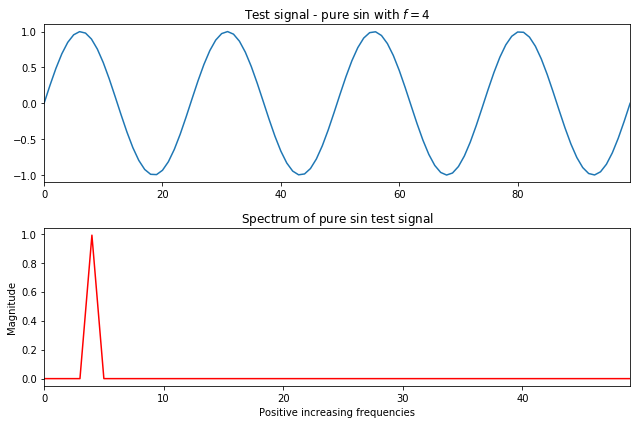

In [15]:
x = np.sin(2 * np.pi * 4 * np.linspace(0, 1, 100))
fig = plt.figure(figsize=(9, 6))
x_plot = plt.subplot(211)
x_plot.plot(x)
x_plot.set_title('Test signal - pure $\sin$ with $f = 4$')
x_plot.set_xlim(0, len(x) - 1)
spectrum_plot = plt.subplot(212)
X = get_magnitude_spectrum(x)
spectrum_plot.plot(X, c='r')
spectrum_plot.set_title('Spectrum of pure $\sin$ test signal')
spectrum_plot.set_xlabel('Positive increasing frequencies')
spectrum_plot.set_ylabel('Magnitude')
spectrum_plot.set_xlim(0, len(X) - 1)
plt.tight_layout()

### Windowing

Windowing helps reduce the _leakage_ problem, where discontinuities at the edge of the analysis window introduce noise throughout the spectrum.  The energy that should be in one spectral harmonic spreads into adjacent harmonics because the DFT assums it is given _one period of an infinitely repeating periodic function_ at the fundamental analysis frequency.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 8))

signal_plot = plt.subplot(221)
signal_plot.set_title('Sine before windowing')
signal_plot.set_xlabel('angle (radians)')
signal_plot.set_ylabel('sin(x)')

spectrum_plot = plt.subplot(222)
spectrum_plot.set_title('Spectrum before windowing')

signal_plot_windowed = plt.subplot(223)
signal_plot_windowed.set_title('Sine after windowing')
signal_plot_windowed.set_xlabel('angle (radians)')
signal_plot_windowed.set_ylabel('sin(x) (Windowed)')

spectrum_plot_windowed = plt.subplot(224)
spectrum_plot_windowed.set_title('Spectrum after windowing\n(using Blackman window)')

N = 64
x = np.linspace(0, 2 * np.pi, N) # multiple of pi will be exactly periodic over window length
signal_line, = signal_plot.plot(x, np.zeros(N), label='Angle (radians)')
X_line, = spectrum_plot.plot(np.zeros(N // 2), color='r')
signal_windowed_line, = signal_plot_windowed.plot(x, np.zeros(N), label='Angle (radians)')
X_line_windowed, = spectrum_plot_windowed.plot(np.zeros(N // 2), color='r')

signal_plot.axis([0, x.max(), -1, 1])
signal_plot_windowed.axis([0, x.max(), -1, 1])
spectrum_plot.axis([0, N // 2 - 1, 0, 1.1])
spectrum_plot_windowed.axis([0, N // 2 - 1, 0, 1.1])
plt.tight_layout()

window = np.blackman(N)
def animate(i):
    freq = (i + 100) / 25
    y = np.sin(freq * x)
    X = get_magnitude_spectrum(y)
    signal_line.set_ydata(y)
    X_line.set_ydata(X)
    spectrum_plot.legend(handles=[X_line], labels=['Freq (radians): {0:.2f}'.format(freq)])

    y_windowed = y * window
    signal_windowed_line.set_ydata(y_windowed)
    X_windowed = get_magnitude_spectrum(y_windowed)
    X_line_windowed.set_ydata(X_windowed)
    spectrum_plot_windowed.legend(handles=[X_line_windowed], labels=['Freq (radians): {0:.3f}'.format(freq)])

create_animation(fig, plt, animate, length_seconds=5)